In [1]:
import numpy as np
import pandas as pd

# Load the datasets

In [12]:
data_dict = {}

In [13]:
task = 'regression'

In [14]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)

ds = data['data']
y_feat = data['target_names'][0]
ds[y_feat] = data['target']

data_dict['calhouse'] = {
    'ds': ds,
    'train_feats': data['feature_names'],
    'cat_feats': [],
    'y_feat': y_feat,
    'task': task
}

In [15]:
from sklearn.datasets import load_boston
data = load_boston()

y_feat = 'price'
fs = data['feature_names']
ds = pd.DataFrame(data['data'], columns=fs)
ds[y_feat] =data['target']

data_dict['boston'] = {
    'ds': ds,
    'train_feats': fs,
    'cat_feats': [],
    'y_feat': y_feat,
    'task': task
}

In [16]:
from sklearn.datasets import load_diabetes
data = load_diabetes(as_frame=True)

ds = data['data']
y_feat = 'disease'
ds[y_feat] = data['target']

data_dict['diabetes'] = {
    'ds': ds,
    'train_feats': data['feature_names'],
    'cat_feats': [],
    'y_feat': y_feat,
    'task': task
}

# Test models

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime

from tqdm import tqdm

In [18]:
import numpy as np
from fcapy.mvcontext.mvcontext import MVContext
from fcapy.mvcontext import pattern_structure as PS
from fcapy.ml.decision_lattice import DecisionLatticeRegressor

from collections.abc import Iterable

In [19]:
import inspect

In [20]:
def form_output(model, params, dt, preds_train, preds_test):
    output = {
        'model': model,
        'params': params,
        'dt': dt,
        'preds_train': preds_train,
        'preds_test': preds_test,
    }
    return output

In [32]:
def fit_decision_tree(X_train, y_train, X_test, all_params):
    params = inspect.signature(DecisionTreeRegressor.__init__).parameters
    params = {k: v for k,v in all_params.items() if k in params}
    
    model = DecisionTreeRegressor(**params)
    t1 = datetime.now()
    model.fit(X_train, y_train)
    t2 = datetime.now()
    dt = (t2-t1).total_seconds()
    
    #preds_train = model.predict(X_train)
    #preds_test = model.predict(X_test)
    
    return model

def fit_random_forest(X_train, y_train, X_test, all_params):
    params = inspect.signature(RandomForestRegressor.__init__).parameters
    params = {k: v for k,v in all_params.items() if k in params}
    
    model = RandomForestRegressor(**params)
    t1 = datetime.now()
    model.fit(X_train, y_train)
    t2 = datetime.now()
    dt = (t2-t1).total_seconds()
    
    #preds_train = model.predict(X_train)
    #preds_test = model.predict(X_test)
    
    return model

def fit_gradient_boosting(X_train, y_train, X_test, all_params):
    params = inspect.signature(GradientBoostingRegressor.__init__).parameters
    params = {k: v for k,v in all_params.items() if k in params}
    
    model = GradientBoostingRegressor(**params)
    t1 = datetime.now()
    model.fit(X_train, y_train)
    t2 = datetime.now()
    dt = (t2-t1).total_seconds()
    
    #preds_train = model.predict(X_train)
    #preds_test = model.predict(X_test)
    
    return model

def fit_xgboost(X_train, y_train, X_test, all_params):
    #params = inspect.signature(XGBRegressor.__init__).parameters
    params = {'n_estimators', 'max_depth'}
    params = {k: v for k,v in all_params.items() if k in params}
    
    model = XGBRegressor(**params)
    t1 = datetime.now()
    model.fit(X_train, y_train)
    t2 = datetime.now()
    dt = (t2-t1).total_seconds()
    
    #preds_train = model.predict(X_train)
    #preds_test = model.predict(X_test)
    
    return model

def fit_model(X_train, y_train, X_test, all_params, model_class):
    if model_class == DecisionTreeRegressor:
        output = fit_decision_tree(X_train, y_train, X_test, all_params)
    elif model_class == RandomForestRegressor:
        output = fit_random_forest(X_train, y_train, X_test, all_params)
    elif model_class == GradientBoostingRegressor:
        output = fit_gradient_boosting(X_train, y_train, X_test, all_params)
    elif model_class == XGBRegressor:
        output = fit_xgboost(X_train, y_train, X_test, all_params)
    else:
        raise ValueError
    
    return output

In [35]:
def fit_dl_dt(K_train, K_test, model):
    t1 = datetime.now()
    model = DecisionLatticeRegressor.from_decision_tree(model, K_train)
    t2 = datetime.now()
    dt = (t2-t1).total_seconds()
    
    preds_train = model.predict(K_train)
    preds_test = model.predict(K_test)
    
    return model

def fit_dl_rf(K_train, K_test, model):
    t1 = datetime.now()
    model = DecisionLatticeRegressor.from_random_forest(model, K_train)
    t2 = datetime.now()
    dt = (t2-t1).total_seconds()
    
    preds_train = model.predict(K_train)
    preds_test = model.predict(K_test)
    
    return model

def fit_dl_gb(K_train, K_test, model):
    t1 = datetime.now()
    model = DecisionLatticeRegressor.from_gradient_boosting(model, K_train)
    t2 = datetime.now()
    dt = (t2-t1).total_seconds()
    
    preds_train = model.predict(K_train)
    preds_test = model.predict(K_test)
    
    return model

def fit_dl_xgb(K_train, K_test, model):
    t1 = datetime.now()
    model = DecisionLatticeRegressor.from_xgboost(model, K_train)
    t2 = datetime.now()
    dt = (t2-t1).total_seconds()
    
    preds_train = model.predict(K_train)
    preds_test = model.predict(K_test)
    
    return model

def fit_dl_from_model(K_train, K_test, model):
    if isinstance(model, DecisionTreeRegressor):
        output = fit_dl_dt(K_train, K_test, model)
    elif isinstance(model, RandomForestRegressor):
        output = fit_dl_rf(K_train, K_test, model)
    elif isinstance(model, GradientBoostingRegressor):
        output = fit_dl_gb(K_train, K_test, model)
    elif isinstance(model, XGBRegressor):
        output = fit_dl_xgb(K_train, K_test, model)
    else:
        raise ValueError
        
    return output

In [36]:
from sklearn.metrics import mean_squared_error

In [101]:
ds['ID'].nunique()==len(ds)

True

In [98]:
ds['Tree'].nunique()

100

In [191]:
dt.decision_path(X_train).shape

(16512, 63)

In [200]:
dt.decision_path(X_train).sum(1).shape

(16512, 1)

In [441]:
def calc_size_dl(model, K):
    output = {
        'n_nodes': len(model._lattice),
        'n_edges': len(model._decisions)
    }
    bottom_concepts, traced_concepts, generators_extents = model._lattice.trace_context(
            K, use_object_indices=True, use_generators=True, use_tqdm=False,
            return_generators_extents=True
    )
    n_active_rules = np.zeros(len(K.object_names))
    for ge in generators_extents:
        n_active_rules[list(ge['ext_'])] += 1
    output['n_drules_active'] = n_active_rules.mean()
    return output

def calc_size_dt(model, X):
    output = {'n_nodes': len(model.tree_.value)}
    output['n_edges'] = output['n_nodes']-1
    #output['n_drules_active'] = (model.decision_path(X).sum(1)).mean()
    
    K = X
    active_drules = np.zeros(len(K.object_names))
    dlr = DecisionLatticeRegressor.from_decision_tree(model, K)
    _,_, generator_extents = dlr._lattice.trace_context(
        K, use_object_indices=True, use_generators=True, use_tqdm=False, return_generators_extents=True)
    for ge in generator_extents:
        active_drules[list(ge['ext_'])] += 1
    output['n_drules_active'] = (active_drules).mean()
    return output

def calc_size_rf(model, X):
    output = {'n_nodes': 0, 'n_edges': 0, 'n_drules_active':0}
    for est in model.estimators_:
        dt_output = calc_size_dt(est, X)
        for f in ['n_nodes', 'n_edges', 'n_drules_active']:
            output[f] += dt_output[f]
    #output['n_drules_active'] = (model.decision_path(X)[0].sum(0)-1).mean()

    return output

def calc_size_gb(model, X):
    output = {'n_nodes': 0, 'n_edges': 0, 'n_drules_active':0}
    for est in model.estimators_.flatten():
        dt_output = calc_size_dt(est, X)
        for f in ['n_nodes', 'n_edges', 'n_drules_active']:
            output[f] += dt_output[f]
    #output['n_drules_active'] = (model.decision_path(X).sum(0)-1).mean()

    return output

def calc_size_xgb(model, K):
    boosters = model.get_booster()
    
    df = boosters.trees_to_dataframe()
    output = {'n_nodes': df['ID'].nunique()}
    output['n_edges'] = output['n_nodes']-df['Tree'].nunique()
    
    active_drules = np.zeros(len(K.object_names))
    for booster in tqdm(boosters, total=xgb.n_estimators):
        dlr = DecisionLatticeRegressor.from_decision_tree(booster, K)
        _,_, generator_extents = dlr._lattice.trace_context(
            K, use_object_indices=True, use_generators=True, use_tqdm=False, return_generators_extents=True)
        for ge in generator_extents:
            active_drules[list(ge['ext_'])] += 1
    output['n_drules_active'] = (active_drules-1).mean()
    
    return output

def calc_model_size(model, X):
    func_map = {
        DecisionTreeRegressor: calc_size_dt,
        RandomForestRegressor: calc_size_rf,
        GradientBoostingRegressor: calc_size_gb,
        XGBRegressor: calc_size_xgb,
        DecisionLatticeRegressor: calc_size_dl,
    }
    return func_map[type(model)](model, X)

In [442]:
def calc_metrics(model, X):
    output = calc_model_size(model, X)
    return output

In [443]:
def form_stat_dict(ens_model, dl_model, ens_metrics, dl_metrics, data_name, kf_idx):
    stat = {
        'ensemble_model': ens_model.__class__.__name__,
        'ds': data_name,
        'fold_id': kf_idx,
    }
    stat = dict(stat, **{f"ensemble_metric_{k}":v for k,v in ens_metrics.items()})
    stat = dict(stat, **{f"dl_metric_{k}":v for k,v in dl_metrics.items()})
    return stat

In [457]:
random_state = 42

model_params_vars = [
    (DecisionTreeRegressor, dict(max_depth=10)),
    (RandomForestRegressor, dict(n_estimators=10, max_depth=6)),
    (GradientBoostingRegressor, dict(n_estimators=10, max_depth=6)),
    (XGBRegressor, dict(n_estimators=10, max_depth=6)),
]
model_params_vars = [
    (cls, dict({'random_state':random_state}, **params))
    for cls, params in model_params_vars
]

In [470]:
%%time

kf = KFold(n_splits=5)
stat_ds = []

for data_name, data in tqdm(data_dict.items(), desc='iterate datasets'):
    ds, train_feats, cat_feats, y_feat = data['ds'], data['train_feats'], data['cat_feats'], data['y_feat']
    train_feats_le = [f+('_le' if f in cat_feats else '') for f in train_feats]
    
    pattern_types = {f: PS.IntervalPS for f in train_feats_le}

    for kf_idx, idxs in tqdm(enumerate(kf.split(ds[train_feats])), desc='KFold', total=kf.n_splits, leave=False):
        train_idxs, test_idxs = idxs
        ds_train, ds_test = ds.loc[train_idxs], ds.loc[test_idxs]
        
        if kf_idx==1:
            break
            
        X_train, X_test = ds_train[train_feats_le], ds_test[train_feats_le]
        y_train, y_test = ds_train[y_feat], ds_test[y_feat]
        
        K_train = MVContext(X_train.values, pattern_types, attribute_names=train_feats_le)
        K_test = MVContext(X_test.values, pattern_types, attribute_names=train_feats_le)
        
        for cls, params in tqdm(model_params_vars, leave=False, desc='iterate models'):
            ens_model = fit_model(X_train, y_train, X_test, params, cls)    
            
            dl_model = fit_dl_from_model(K_train, K_test, ens_model)
            
            ens_metrics = calc_metrics(ens_model, K_train) #X_train if cls!=XGBRegressor else K_train)
            dl_metrics = calc_metrics(dl_model, K_train)
            
            stat = form_stat_dict(ens_model, dl_model, ens_metrics, dl_metrics, data_name, kf_idx)
            stat_ds.append(pd.Series(stat))
            
        pd.concat(stat_ds,1, sort=False).T.to_csv('tmp_evaluation_interpr.csv')
pd.concat(stat_ds,1, sort=False).T.to_csv('evaluation_interpr_full_10est6depth.csv')
!rm tmp_evaluation_interpr.csv

KFold:   0%|          | 0/5 [00:00<?, ?it/s]

iterate models:   0%|          | 0/4 [00:00<?, ?it/s]

iterate models:  25%|██▌       | 1/4 [00:56<02:48, 56.01s/it]

iterate models:  50%|█████     | 2/4 [07:43<05:22, 161.44s/it]

iterate models:  75%|███████▌  | 3/4 [14:15<03:50, 230.62s/it]


  0%|          | 0/3 [00:00<?, ?it/s]


 33%|███▎      | 1/3 [00:18<00:37, 18.51s/it]


 67%|██████▋   | 2/3 [00:36<00:18, 18.23s/it]


100%|██████████| 3/3 [00:55<00:00, 18.59s/it]


4it [01:15, 19.04s/it]                       


5it [01:34, 19.04s/it]


6it [01:54, 19.18s/it]


7it [02:12, 19.00s/it]


8it [02:30, 18.66s/it]


9it [02:49, 18.83s/it]


10it [03:08, 18.85s/it]


iterate models: 100%|██████████| 4/4 [20:42<00:00, 277.52s/it]

                                                              
KFold:   0%|          | 0/5 [00:00<?, ?it/s]

iterate models:   0%|          | 0/4 [00:00<?, ?it/s]

iterate models:  25%|██▌       | 1/4 [00:01<00:05,  1.98s/it]

iterate models:  50%|█████     | 

CPU times: user 22min 8s, sys: 9.6 s, total: 22min 18s
Wall time: 22min 7s


# Analysis

In [480]:
df = pd.read_csv('evaluation_interpr_full_10est6depth.csv', index_col=0)
df.head()

,ensemble_model,ds,fold_id,ensemble_metric_n_nodes,ensemble_metric_n_edges,ensemble_metric_n_drules_active,dl_metric_n_nodes,dl_metric_n_edges,dl_metric_n_drules_active
0,DecisionTreeRegressor,calhouse,0,1543,1542,10.989583,1544,1543,10.989583
1,RandomForestRegressor,calhouse,0,1256,1246,69.999455,1220,1245,60.994247
2,GradientBoostingRegressor,calhouse,0,1268,1258,69.999939,1161,1189,60.287185
3,XGBRegressor,calhouse,0,1222,1212,68.984557,1208,1211,60.984012
4,DecisionTreeRegressor,boston,0,353,352,10.254950,354,353,10.254950


In [481]:
import seaborn as sns

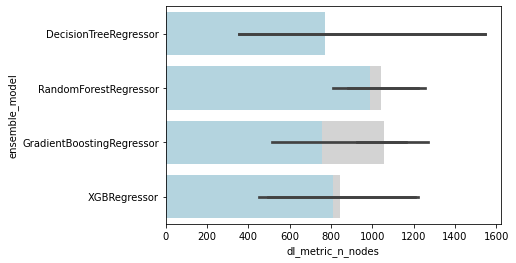

In [482]:
sns.barplot(y='ensemble_model', x='ensemble_metric_n_nodes', data=df, color='lightgrey')
sns.barplot(y='ensemble_model', x='dl_metric_n_nodes', data=df, color='lightblue')

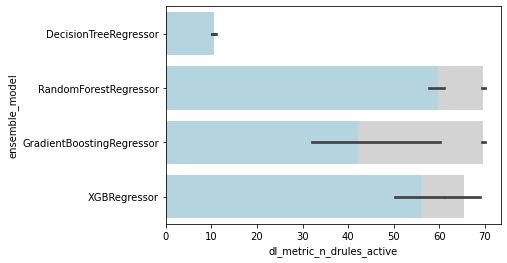

In [483]:
sns.barplot(y='ensemble_model', x='ensemble_metric_n_drules_active', data=df, color='lightgrey')
sns.barplot(y='ensemble_model', x='dl_metric_n_drules_active', data=df, color='lightblue')

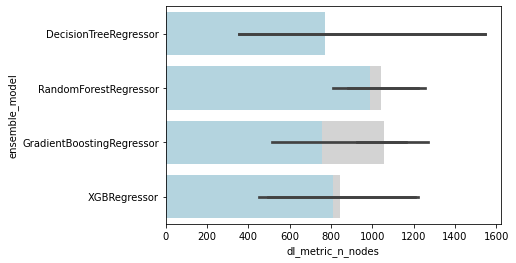

In [484]:
sns.barplot(y='ensemble_model', x='ensemble_metric_n_nodes', data=df, color='lightgrey')
sns.barplot(y='ensemble_model', x='dl_metric_n_nodes', data=df, color='lightblue')

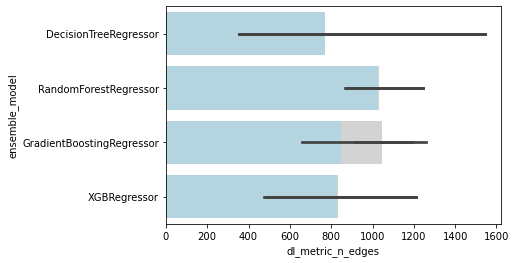

In [485]:
sns.barplot(y='ensemble_model', x='ensemble_metric_n_edges', data=df, color='lightgrey')
sns.barplot(y='ensemble_model', x='dl_metric_n_edges', data=df, color='lightblue')

In [486]:
cds = df.copy()
cds = cds.groupby(['ensemble_model','ds'])[[
    'ensemble_metric_n_nodes','ensemble_metric_n_edges','dl_metric_n_nodes','dl_metric_n_edges'
]].mean()#.reset_index()

cds['n_nodes_delta'] = cds['ensemble_metric_n_nodes']-cds['dl_metric_n_nodes']
cds['n_edges_delta'] = cds['ensemble_metric_n_edges']-cds['dl_metric_n_edges']
cds['n_nodes_delta_perc'] = cds['n_nodes_delta']/cds['ensemble_metric_n_nodes']*100
cds['n_edges_delta_perc'] = cds['n_edges_delta']/cds['ensemble_metric_n_edges']*100
cds = cds[[
    #'ensemble_model', 'ds',
    'ensemble_metric_n_nodes', 'dl_metric_n_nodes', 'n_nodes_delta_perc',
    'ensemble_metric_n_edges', 'dl_metric_n_edges', 'n_edges_delta_perc'
]].round(2)
cds

ensemble_metric_n_nodes  \
ensemble_model            ds                                  
DecisionTreeRegressor     boston                        353   
                          calhouse                     1543   
                          diabetes                      413   
GradientBoostingRegressor boston                        924   
                          calhouse                     1268   
                          diabetes                      974   
RandomForestRegressor     boston                        884   
                          calhouse                     1256   
                          diabetes                      980   
XGBRegressor              boston                        496   
                          calhouse                     1222   
                          diabetes                      808   

                                    dl_metric_n_nodes  n_nodes_delta_perc  \
ensemble_model            ds                                                
DecisionTreeRegressor     boston                  354               -0.28   
                          calhouse               1544               -0.06   
                          diabetes                414               -0.24   
GradientBoostingRegressor boston                  515               44.26   
                          calhouse               1161                8.44   
                          diabetes                594               39.01   
RandomForestRegressor     boston                  809                8.48   
                          calhouse               1220                2.87   
                          diabetes                931                5.00   
XGBRegressor              boston                  452                8.87   
                          calhouse               1208                1.15   
                          diabetes                761                5.82   

                                    ensemble_metric_n_edges  \
ensemble_model            ds                                  
DecisionTreeRegressor     boston                        352   
                          calhouse                     1542   
                          diabetes                      412   
GradientBoostingRegressor boston                        914   
                          calhouse                     1258   
                          diabetes                      964   
RandomForestRegressor     boston                        874   
                          calhouse                     1246   
                          diabetes                      970   
XGBRegressor              boston                        486   
                          calhouse                     1212   
                          diabetes                      798   

                                    dl_metric_n_edges  n_edges_delta_perc  
ensemble_model            ds                                               
DecisionTreeRegressor     boston                  353               -0.28  
                          calhouse               1543               -0.06  
                          diabetes                413               -0.24  
GradientBoostingRegressor boston                  661               27.68  
                          calhouse               1189                5.48  
                          diabetes                699               27.49  
RandomForestRegressor     boston                  865                1.03  
                          calhouse               1245                0.08  
                          diabetes                971               -0.10  
XGBRegressor              boston                  475                2.26  
                          calhouse               1211                0.08  
                          diabetes                797                0.13

In [503]:
cds = df.copy()
cds = cds.groupby(['ensemble_model','ds'])[[
    'ensemble_metric_n_drules_active', 'dl_metric_n_drules_active'
]].mean()#.reset_index()

cds['n_drules_active_delta'] = cds['ensemble_metric_n_drules_active']-cds['dl_metric_n_drules_active']
cds['n_drules_active_delta_perc'] = cds['n_drules_active_delta']/cds['ensemble_metric_n_drules_active']*100
cds = cds[[
    #'ensemble_model', 'ds',
    'ensemble_metric_n_drules_active', 'dl_metric_n_drules_active', 'n_drules_active_delta_perc',
]].round(2)

cds.index.names = ['Base model','Dataset']
cds = cds.rename(columns={
    'ensemble_metric_n_drules_active': 'Base model',
    'dl_metric_n_drules_active': 'DL',
    'n_drules_active_delta_perc': r'$\Delta (\%)$'
})

cds

Base model     DL  $\Delta (\%)$
Base model                Dataset                                   
DecisionTreeRegressor     boston         10.25  10.25           0.00
                          calhouse       10.99  10.99           0.00
                          diabetes       10.22  10.22           0.00
GradientBoostingRegressor boston         69.50  34.54          50.30
                          calhouse       70.00  60.29          13.88
                          diabetes       69.68  31.99          54.09
RandomForestRegressor     boston         69.32  57.86          16.54
                          calhouse       70.00  60.99          12.86
                          diabetes       69.33  60.32          13.00
XGBRegressor              boston         61.38  50.20          18.21
                          calhouse       68.98  60.98          11.60
                          diabetes       65.96  56.96          13.64

In [516]:
cds = df.copy()
cds = cds.groupby(['ensemble_model','ds'])[[
    'ensemble_metric_n_nodes', 'dl_metric_n_nodes',
    'ensemble_metric_n_drules_active', 'dl_metric_n_drules_active'
]].mean()#.reset_index()
cds['ensemble_metric_n_nodes'] += 1

cds['n_nodes_delta'] = cds['ensemble_metric_n_nodes']-cds['dl_metric_n_nodes']
cds['n_nodes_delta_perc'] = cds['n_nodes_delta']/cds['ensemble_metric_n_nodes']*100

cds['n_drules_active_delta'] = cds['ensemble_metric_n_drules_active']-cds['dl_metric_n_drules_active']
cds['n_drules_active_delta_perc'] = cds['n_drules_active_delta']/cds['ensemble_metric_n_drules_active']*100
cds = cds[[
    #'ensemble_model', 'ds',
    'ensemble_metric_n_nodes', 'dl_metric_n_nodes', 'n_nodes_delta_perc',
    'ensemble_metric_n_drules_active', 'dl_metric_n_drules_active', 'n_drules_active_delta_perc',
]].round(2)

cds.columns = pd.MultiIndex.from_tuples([
    ('# decision rules', 'Base model'), ('# decision rules', 'DL'), ('# decision rules', r'$\Delta (\%)$'),
    ('Avg. # decision rules to desribe an object', 'Base model'), ('Avg. # decision rules to desribe an object', 'DL'), ('Avg. # decision rules to desribe an object', r'$\Delta (\%)$'),
])

cds.index.names = ['Base model','Dataset']

#cds = cds.rename(columns={
#    'ensemble_metric_n_drules_active': 'Base model',
#    'dl_metric_n_drules_active': 'DL',
#    'n_drules_active_delta_perc': r'$\Delta (\%)$'
#})

cds

# decision rules                      \
                                         Base model    DL $\Delta (\%)$   
Base model                Dataset                                         
DecisionTreeRegressor     boston                354   354          0.00   
                          calhouse             1544  1544          0.00   
                          diabetes              414   414          0.00   
GradientBoostingRegressor boston                925   515         44.32   
                          calhouse             1269  1161          8.51   
                          diabetes              975   594         39.08   
RandomForestRegressor     boston                885   809          8.59   
                          calhouse             1257  1220          2.94   
                          diabetes              981   931          5.10   
XGBRegressor              boston                497   452          9.05   
                          calhouse             1223  1208          1.23   
                          diabetes              809   761          5.93   

                                   Avg. # decision rules to desribe an object  \
                                                                   Base model   
Base model                Dataset                                               
DecisionTreeRegressor     boston                                        10.25   
                          calhouse                                      10.99   
                          diabetes                                      10.22   
GradientBoostingRegressor boston                                        69.50   
                          calhouse                                      70.00   
                          diabetes                                      69.68   
RandomForestRegressor     boston                                        69.32   
                          calhouse                                      70.00   
                          diabetes                                      69.33   
XGBRegressor              boston                                        61.38   
                          calhouse                                      68.98   
                          diabetes                                      65.96   

                                                         
                                       DL $\Delta (\%)$  
Base model                Dataset                        
DecisionTreeRegressor     boston    10.25          0.00  
                          calhouse  10.99          0.00  
                          diabetes  10.22          0.00  
GradientBoostingRegressor boston    34.54         50.30  
                          calhouse  60.29         13.88  
                          diabetes  31.99         54.09  
RandomForestRegressor     boston    57.86         16.54  
                          calhouse  60.99         12.86  
                          diabetes  60.32         13.00  
XGBRegressor              boston    50.20         18.21  
                          calhouse  60.98         11.60  
                          diabetes  56.96         13.64

In [518]:
print(cds.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
             &          & \multicolumn{3}{l}{\# decision rules} & \multicolumn{3}{l}{Avg. \# decision rules to desribe an object} \\
             &          &       Base model &    DL & \$\textbackslash Delta (\textbackslash \%)\$ &                                 Base model &     DL & \$\textbackslash Delta (\textbackslash \%)\$ \\
Base model & Dataset &                  &       &               &                                            &        &               \\
\midrule
DecisionTreeRegressor & boston &              354 &   354 &          0.00 &                                      10.25 &  10.25 &          0.00 \\
             & calhouse &             1544 &  1544 &          0.00 &                                      10.99 &  10.99 &          0.00 \\
             & diabetes &              414 &   414 &          0.00 &                                      10.22 &  10.22 &          0.00 \\
GradientBoostingRegressor & boston &              925 &  

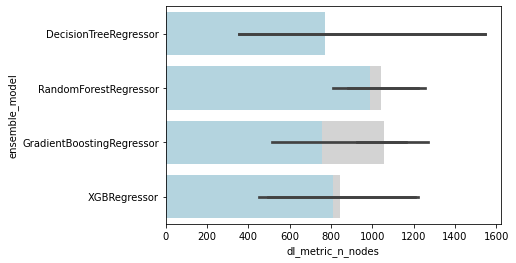

In [171]:
sns.barplot(y='ensemble_model', x='ensemble_metric_n_nodes', data=df, color='lightgrey')
sns.barplot(y='ensemble_model', x='dl_metric_n_nodes', data=df, color='lightblue')

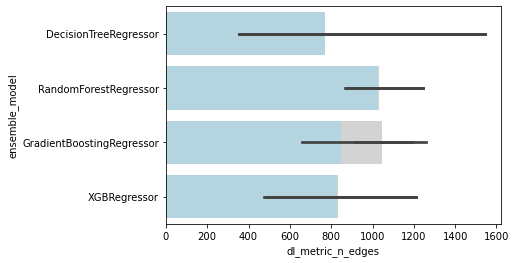

In [177]:
sns.barplot(y='ensemble_model', x='ensemble_metric_n_edges', data=df, color='lightgrey')
sns.barplot(y='ensemble_model', x='dl_metric_n_edges', data=df, color='lightblue')

In [173]:
cds = df.copy()
cds = cds.groupby(['ensemble_model','ds'])[[
    'ensemble_metric_n_nodes','ensemble_metric_n_edges','dl_metric_n_nodes','dl_metric_n_edges'
]].mean()#.reset_index()

cds['n_nodes_delta'] = cds['ensemble_metric_n_nodes']-cds['dl_metric_n_nodes']
cds['n_edges_delta'] = cds['ensemble_metric_n_edges']-cds['dl_metric_n_edges']
cds['n_nodes_delta_perc'] = cds['n_nodes_delta']/cds['ensemble_metric_n_nodes']*100
cds['n_edges_delta_perc'] = cds['n_edges_delta']/cds['ensemble_metric_n_edges']*100
cds = cds[[
    #'ensemble_model', 'ds',
    'ensemble_metric_n_nodes', 'dl_metric_n_nodes', 'n_nodes_delta_perc',
    'ensemble_metric_n_edges', 'dl_metric_n_edges', 'n_edges_delta_perc'
]].round(2)
cds

ensemble_metric_n_nodes  \
ensemble_model            ds                                  
DecisionTreeRegressor     boston                        353   
                          calhouse                     1543   
                          diabetes                      413   
GradientBoostingRegressor boston                        924   
                          calhouse                     1268   
                          diabetes                      974   
RandomForestRegressor     boston                        884   
                          calhouse                     1256   
                          diabetes                      980   
XGBRegressor              boston                        496   
                          calhouse                     1222   
                          diabetes                      808   

                                    dl_metric_n_nodes  n_nodes_delta_perc  \
ensemble_model            ds                                                
DecisionTreeRegressor     boston                  354               -0.28   
                          calhouse               1544               -0.06   
                          diabetes                414               -0.24   
GradientBoostingRegressor boston                  515               44.26   
                          calhouse               1161                8.44   
                          diabetes                594               39.01   
RandomForestRegressor     boston                  809                8.48   
                          calhouse               1220                2.87   
                          diabetes                931                5.00   
XGBRegressor              boston                  452                8.87   
                          calhouse               1208                1.15   
                          diabetes                761                5.82   

                                    ensemble_metric_n_edges  \
ensemble_model            ds                                  
DecisionTreeRegressor     boston                        352   
                          calhouse                     1542   
                          diabetes                      412   
GradientBoostingRegressor boston                        914   
                          calhouse                     1258   
                          diabetes                      964   
RandomForestRegressor     boston                        874   
                          calhouse                     1246   
                          diabetes                      970   
XGBRegressor              boston                        486   
                          calhouse                     1212   
                          diabetes                      798   

                                    dl_metric_n_edges  n_edges_delta_perc  
ensemble_model            ds                                               
DecisionTreeRegressor     boston                  353               -0.28  
                          calhouse               1543               -0.06  
                          diabetes                413               -0.24  
GradientBoostingRegressor boston                  661               27.68  
                          calhouse               1189                5.48  
                          diabetes                699               27.49  
RandomForestRegressor     boston                  865                1.03  
                          calhouse               1245                0.08  
                          diabetes                971               -0.10  
XGBRegressor              boston                  475                2.26  
                          calhouse               1211                0.08  
                          diabetes                797                0.13